In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product

from utils import SECTORS, DR_PRICES, NG_PRICES, NAT_GAS_NICE_NAMES, DR_PRICE_NICE_NAMES, SECTOR_NICE_NAMES, get_datapoint

In [44]:
# User defined variables
METHOD = "static" # "static" | "dynamic"
REGION = "new_england" # "caiso" | "new_england"

In [45]:
# Path handling (DO NOT CHANGE)
FIGURES_BASE = Path("..","figures","scatter")
FIGURES_METHOD = Path(FIGURES_BASE, REGION,METHOD)

In [46]:

def get_scatter_data(result: str, metric: str) -> pd.DataFrame:
    
    data = {}
    
    for ng_price in NG_PRICES:
        e_data = []
        for sector, dr_price in product(SECTORS, DR_PRICES):
            costs = get_datapoint(
                region=REGION,
                method=METHOD,
                ng_price=ng_price,
                sector=sector,
                dr_price=dr_price,
                result="cost"
            )
            df = get_datapoint(
                region=REGION,
                method=METHOD,
                ng_price=ng_price,
                sector=sector,
                dr_price=dr_price,
                result=result
            )
        
            obj = costs.at["objective", "value"] / 1e9
            datapoint = df.at[metric, "value"]
        
            e_data.append([obj, datapoint, sector, dr_price])

        data[ng_price] = pd.DataFrame(
            e_data, 
            columns=[
                "Objective",
                metric,
                "Sector",
                "Price"
            ]
        )
    
    return data

In [47]:
def generate_scatterplot(data: dict[str, pd.DataFrame], ylabel: Optional[str] = None, **kwargs) -> tuple[plt.figure, plt.axes]:
    
    fig, axs = plt.subplots(1,3, sharey=True)
    
    ax = 0
    handles, labels = [], []
    
    for er, df in data.items():
        df["Sector"] = df.Sector.map(SECTOR_NICE_NAMES)
        df["DR Price"] = df.Price.map(DR_PRICE_NICE_NAMES)
        metric = df.columns[1]
        scatter = sns.scatterplot(data=df, x="Objective", y=metric, hue="Sector", style="Price", ax=axs[ax], legend=True, s=50)
        axs[ax].set_title(NAT_GAS_NICE_NAMES[er])
        axs[ax].set_ylabel("")
        axs[ax].set_xlabel("")
        
        # Collect handles and labels for shared legend
        h, l = scatter.get_legend_handles_labels()
        if not handles:  # Avoid duplicates by only collecting from the first plot
            handles, labels = h, l
            
        axs[ax].legend_.remove()
        
        ax += 1

    fig.legend(
        handles, 
        labels, 
        loc="center left", 
        bbox_to_anchor=(1, 0.5),  # Position to the right of the figure
        ncol=1, 
        frameon=False,
    )
    
    fig.supxlabel("Objective Cost ($B)")
    if ylabel:
        fig.supylabel(ylabel)
    
    # plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    fig.tight_layout(rect=[0, 0, 1, 0.95]) 
    
    return fig, axs

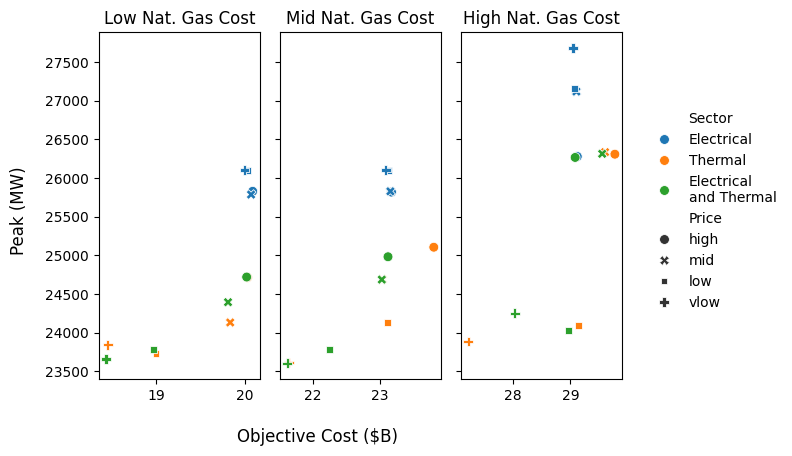

In [48]:
data = get_scatter_data("peakiness", "peak")
fig, _ = generate_scatterplot(data, ylabel = "Peak (MW)")
save_f = Path(FIGURES_METHOD, "peak_net_load.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

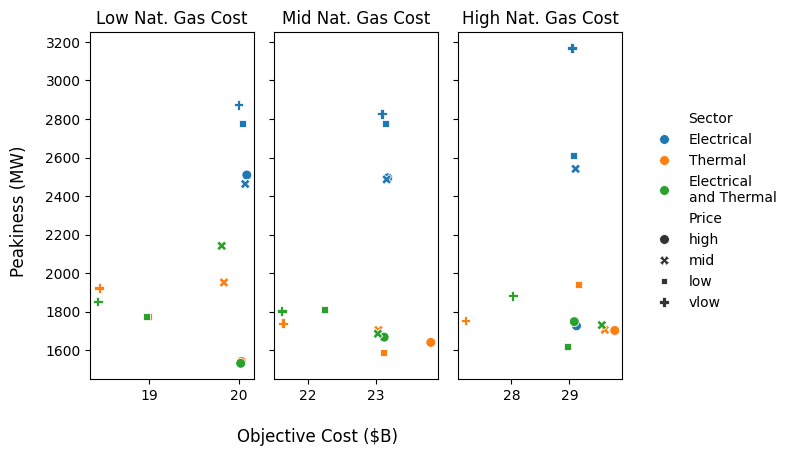

In [49]:
data = get_scatter_data("peakiness", "peakiness")
fig, _ = generate_scatterplot(data, ylabel = "Peakiness (MW)")
save_f = Path(FIGURES_METHOD, "peakiness.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

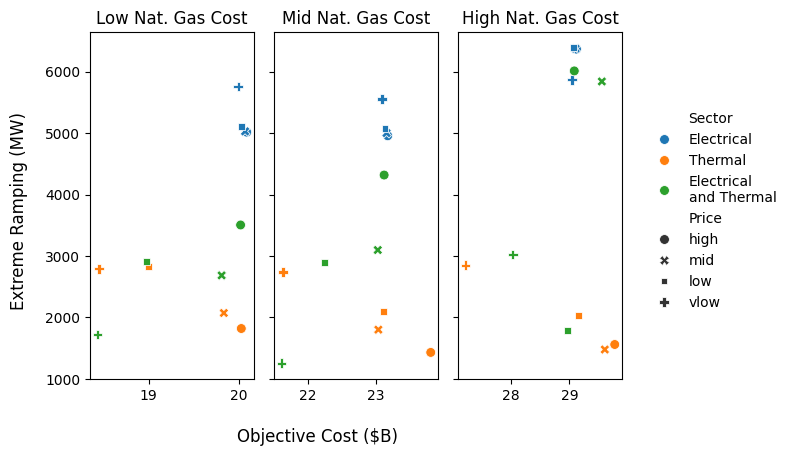

In [50]:
data = get_scatter_data("ramping", "extreme")
fig, _ = generate_scatterplot(data, ylabel = "Extreme Ramping (MW)")
save_f = Path(FIGURES_METHOD, "extreme_ramping.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

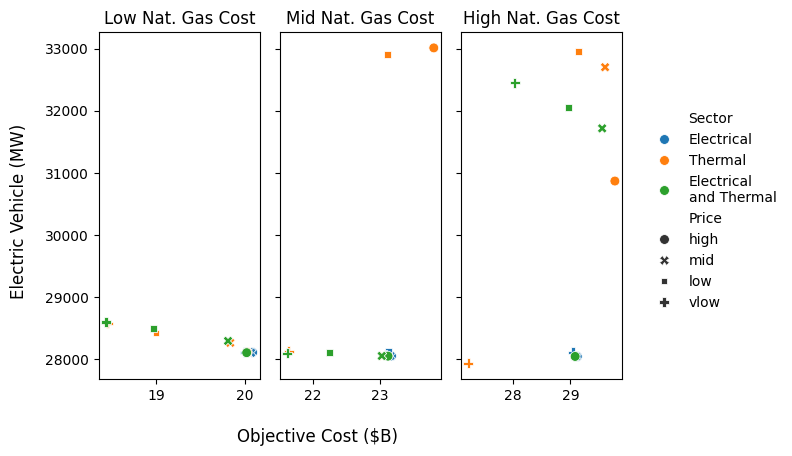

In [51]:
data = get_scatter_data("capacity", "Transport Electric")
fig, _ = generate_scatterplot(data, ylabel = "Electric Vehicle (MW)")
save_f = Path(FIGURES_METHOD, "evs_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

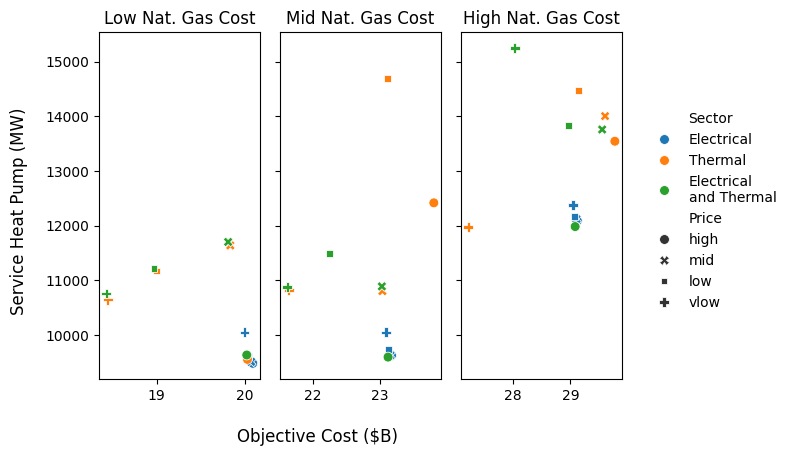

In [52]:
data = get_scatter_data("capacity", "Service Heat Pump")
fig, _ = generate_scatterplot(data, ylabel = "Service Heat Pump (MW)")
save_f = Path(FIGURES_METHOD, "service_heat_pump.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

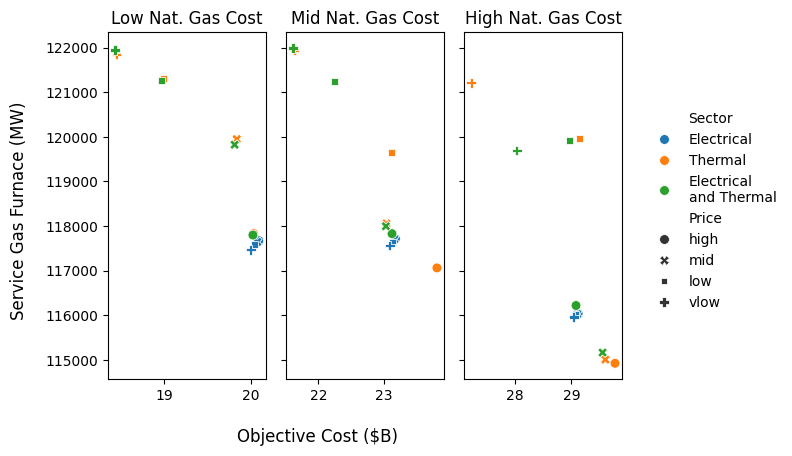

In [53]:
data = get_scatter_data("capacity", "Service Gas Furnace")
fig, _ = generate_scatterplot(data, ylabel = "Service Gas Furnace (MW)")
save_f = Path(FIGURES_METHOD, "service_gas_furnace.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

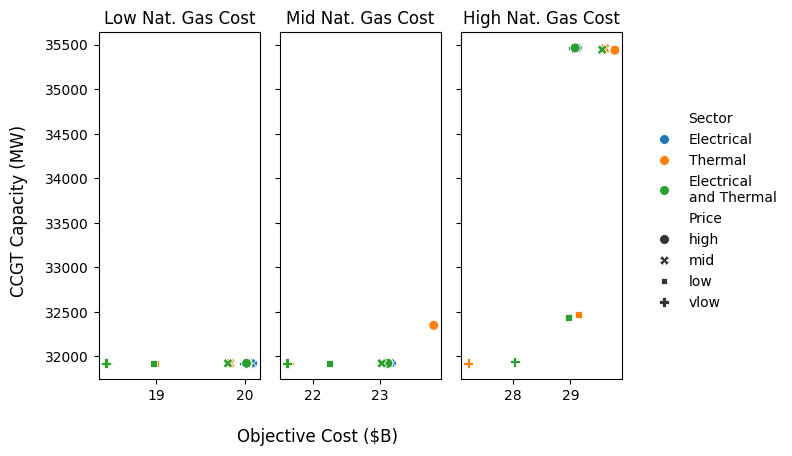

In [54]:
data = get_scatter_data("capacity", "Natural Gas CCGT")
fig, _ = generate_scatterplot(data, ylabel = "CCGT Capacity (MW)")
save_f = Path(FIGURES_METHOD, "ccgt_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

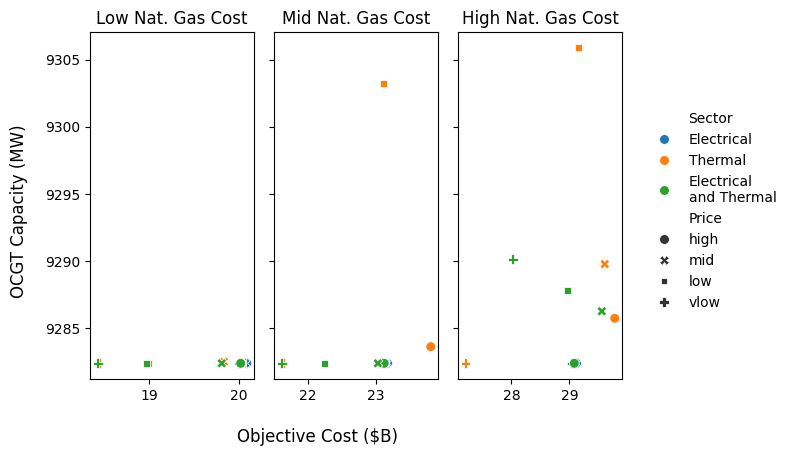

In [55]:
data = get_scatter_data("capacity", "Natural Gas OCGT")
fig, _ = generate_scatterplot(data, ylabel = "OCGT Capacity (MW)")
save_f = Path(FIGURES_METHOD, "ocgt_capacity.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)

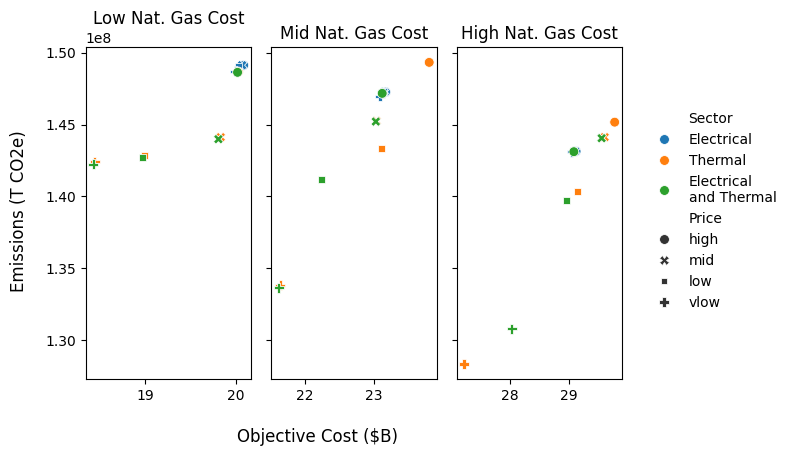

In [56]:
data = get_scatter_data("emissions", "Emissions CO2 T")
fig, _ = generate_scatterplot(data, ylabel = "Emissions (T CO2e)")
save_f = Path(FIGURES_METHOD, "emissions.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, bbox_inches="tight", dpi=300)